In [9]:
"""
Plot:
    - Feature correlation matrix
    - Feature importance

"""





import numpy as np
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from standardizer import normate_dataset_period
import datetime as datetime
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from preprocessor import preprocessor
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict


In [2]:
data_paths = [ './data/'+file for file in os.listdir("./data/") if file.split('_')[0] + file.split('_')[1]=='punchnorm' and file.split('_')[-1]=='20000.csv' ]
raw_data_path = "./data/complete_smartpunch_dataset_7606punches.json"

data_paths.insert(0, raw_data_path)
data_paths = data_paths[0:1]
print(data_paths)

['./data/complete_smartpunch_dataset_7606punches.json']


# Pre-process data and train random forest

In [3]:



results_file = './results.csv'
#Initialize tuned random forest
clf = RandomForestClassifier(criterion='entropy', max_depth=80, n_estimators=120)

for row_idx,data_path in enumerate(data_paths):
    
    
    #if data is the raw data file
    if data_path.split('.')[-1]=='json':
        processor = preprocessor(filepath=data_path, data_stage='raw')
        processor.pre_process()
        period_length = 0
        sampling_rate = 0
        
    #else data is already processed
    else:
        processor = preprocessor(filepath=data_path, data_stage='processed')
        period_length = int( data_path.split('_')[2] )
        sampling_rate = int( data_path.split('_')[3].split('.')[0] )
        
        
    features = processor.extract_features()
    labels = processor.get_labels()
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)
    
    norm = MinMaxScaler().fit(X_train)
    
    X_train = norm.transform(X_train)
    X_test = norm.transform(X_test)
    
    clf.fit(X_train, y_train)
    print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))
    
    
    

    
    
    

Feature Extraction: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Accuracy on test data: 0.99


Index(['x__sum_values', 'x__median', 'x__mean', 'x__length',
       'x__standard_deviation', 'x__variance', 'x__root_mean_square',
       'x__maximum', 'x__absolute_maximum', 'x__minimum', 'y__sum_values',
       'y__median', 'y__mean', 'y__length', 'y__standard_deviation',
       'y__variance', 'y__root_mean_square', 'y__maximum',
       'y__absolute_maximum', 'y__minimum', 'z__sum_values', 'z__median',
       'z__mean', 'z__length', 'z__standard_deviation', 'z__variance',
       'z__root_mean_square', 'z__maximum', 'z__absolute_maximum',
       'z__minimum'],
      dtype='object')


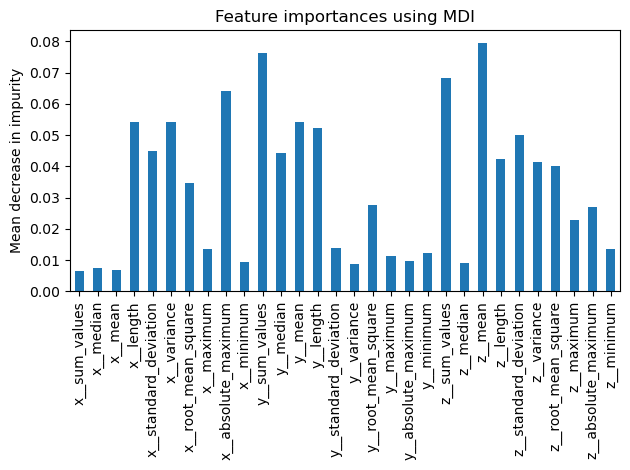

In [10]:
feature_names = features.keys()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [79]:
fig.savefig("feature_MDI_forest.png")

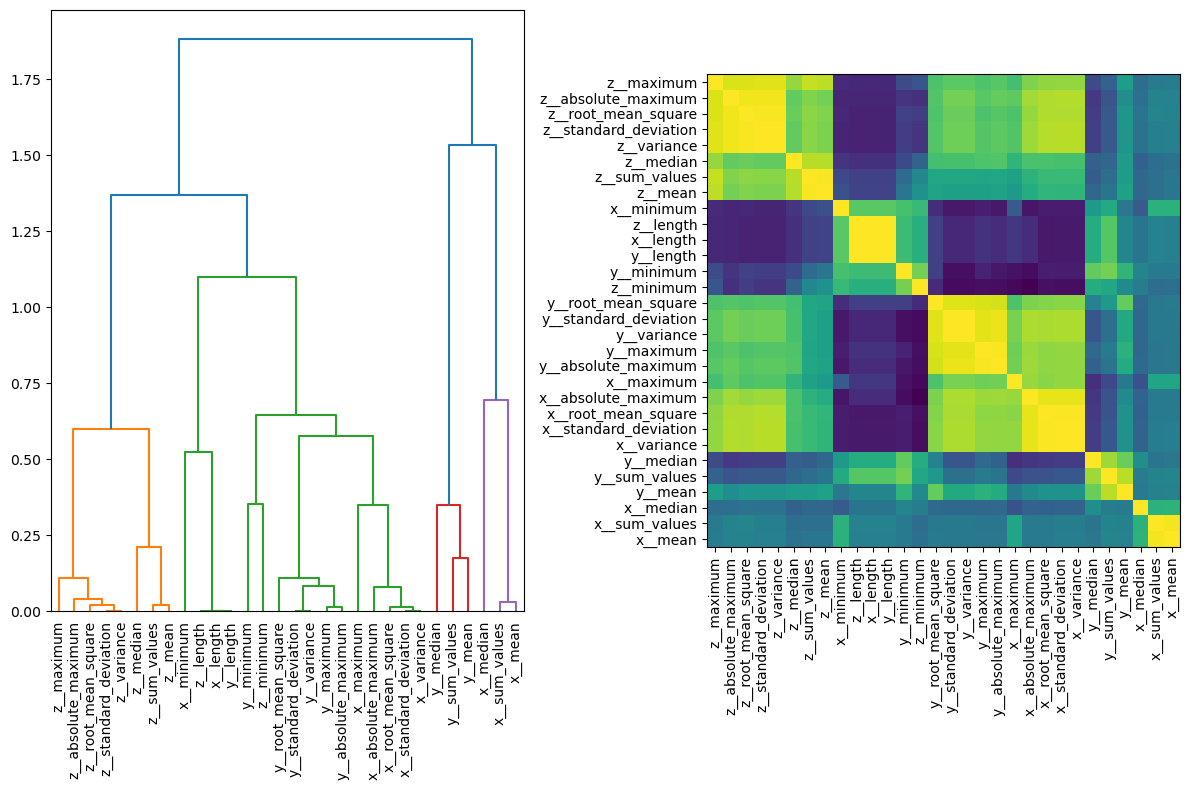

In [11]:

#***************************************************************************************/
#*    Code from: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
#*    Under header: Handling Multicollinear Features
#*    Date: 19/5/2023
#***************************************************************************************/




fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(features).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=features.keys().tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()